## ResNet-50 Analysis

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, cohen_kappa_score, roc_auc_score, confusion_matrix
import os
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 A utilizar dispositivo: {device}")

# --- CONFIGURAÇÃO KAGGLE ---
# Substitui 'odir-5k-processed' pelo nome exato que deste ao dataset no upload
DATASET_NAME = "odir-5k-processed/odir-project/data/odir5k" 

DATASET_ROOT = f"/kaggle/input/{DATASET_NAME}"
DATASET_PATH = DATASET_ROOT # Para manter compatibilidade com o teu código abaixo

# No Kaggle, só podes escrever em /kaggle/working
MODEL_SAVE_PATH = "/kaggle/working"
CURRENT_DIR = "/kaggle/working"

if os.path.exists(DATASET_ROOT):
    print(f"✅ Sucesso: Dados encontrados em: {DATASET_ROOT}")
    print(f"📂 Conteúdo: {os.listdir(DATASET_ROOT)}")
else:
    print(f"❌ Erro: Pasta {DATASET_ROOT} não encontrada! Verifica o nome do dataset.")

🚀 A utilizar dispositivo: cuda
✅ Sucesso: Dados encontrados em: /kaggle/input/odir-5k-processed/odir-project/data/odir5k
📂 Conteúdo: ['README.md', 'val', 'original', 'test', 'train']


In [3]:
import json
import numpy as np

def save_results_to_json(results_dict, filename="odir_experiment_results.json"):
    # Criamos uma cópia para não estragar os dados originais
    serializable_results = {}
    
    for version, data in results_dict.items():
        serializable_results[version] = {
            # O histórico já costuma ser lista, mas garantimos
            'history': data['history'],
            # Convertemos arrays NumPy em listas para o JSON aceitar
            'y_true': data['y_true'].tolist() if isinstance(data['y_true'], np.ndarray) else data['y_true'],
            'y_probs': data['y_probs'].tolist() if isinstance(data['y_probs'], np.ndarray) else data['y_probs']
        }
    
    with open(filename, 'w') as f:
        json.dump(serializable_results, f)
    print(f"✅ Resultados salvos com sucesso em: {filename}")


In [4]:
import json # <--- Adiciona isto aqui!
def load_results_from_json(filename="odir_experiment_results.json"):
    try:
        with open(filename, 'r') as f:
            data = json.load(f)
        
        # Voltamos a converter as listas em arrays NumPy para os teus gráficos funcionarem
        for version in data:
            data[version]['y_true'] = np.array(data[version]['y_true'])
            data[version]['y_probs'] = np.array(data[version]['y_probs'])
            
        print(f"✅ {len(data)} versões carregadas do ficheiro.")
        return data
    except FileNotFoundError:
        print("⚠️ Ficheiro não encontrado. A começar dicionário vazio.")
        return {}

# --- COMO USAR AO ABRIR O NOTEBOOK ---
# Tenta este caminho baseado na estrutura do teu painel lateral
results_logs = load_results_from_json(filename="/kaggle/input/odir-experiment-results-json/odir_experiment_results.json")

✅ 4 versões carregadas do ficheiro.


In [5]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Converte para LAB para aplicar CLAHE apenas na luminosidade
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

def apply_crop(image):
    # Tua lógica de remoção de bordas pretas (Crop automático)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask = gray > 10
    return image[np.ix_(mask.any(1), mask.any(0))]

In [6]:
DATA_DIR = DATASET_ROOT

def get_df_from_dir(folder_name):
    """
    Simulação da lógica que você usou no Modelo 03/Notebook 01 
    para extrair nomes de ficheiros e labels sem depender de CSVs.
    """
    path = os.path.join(DATA_DIR, folder_name)
    files = [f for f in os.listdir(path) if f.endswith(('.jpg', '.png'))]
    
    # Criar DataFrame básico
    df = pd.DataFrame({'filename': files})
    
    # Extrair labels do nome do ficheiro ou metadados integrados
    for cls in ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']:
        df[cls] = 0 # Placeholder: substitua pela lógica de preenchimento real se necessário
    
    return df

# Carregar DataFrames em memória
train_df = get_df_from_dir('train')
val_df = get_df_from_dir('val')
test_df = get_df_from_dir('test')

print(f"Dados carregados: Train({len(train_df)}), Val({len(val_df)}), Test({len(test_df)})")

Dados carregados: Train(5732), Val(1728), Test(1748)


In [7]:
class ODIRDataset(Dataset):
    def __init__(self, split='train', transform=None):
        self.split = split
        self.transform = transform
        
        # O caminho deve apontar para data/odir5k/train (ou val/test)
        self.img_dir = os.path.join(DATASET_ROOT, split)
        
        # Procura o CSV gerado pelo pré-processamento do Notebook 1
        metadata_path = os.path.join(self.img_dir, f"{split}_metadata.csv")
        
        if not os.path.exists(metadata_path):
            raise FileNotFoundError(f"⚠️ Não encontrei o ficheiro: {metadata_path}. Correstes o Notebook 1?")
            
        self.data = pd.read_csv(metadata_path)
        
        # Lista as colunas de doenças (N, D, G, C, A, H, M, O)
        self.label_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # O Notebook 1 guarda o nome da imagem na coluna 'filename'
        img_name = row['filename']
        img_path = os.path.join(self.img_dir, img_name)
        
        # Carregar imagem
        image = Image.open(img_path).convert('RGB')
        
        # Carregar labels como tensor
        labels = torch.tensor(row[self.label_cols].values.astype(np.float32))
        
        if self.transform:
            image = self.transform(image)
            
        return image, labels
def get_transforms(config):
    t_list = []
    # Crop Otimizado
    if config['crop']:
        t_list.append(transforms.Lambda(lambda img: crop_borders(img)))
    
    t_list.append(transforms.Resize((224, 224)))
    
    # Data Augmentation (V3 e V4)
    if config['augment'] == 'full':
        t_list.extend([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.1, contrast=0.1)
        ])
    
    # CLAHE Adaptativo
    if config['clahe']:
        t_list.append(transforms.Lambda(lambda img: apply_clahe(img)))
        
    t_list.extend([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transforms.Compose(t_list)

def crop_borders(img):
    img_np = np.array(img)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    mask = gray > 10
    if not np.any(mask): return img
    coords = np.argwhere(mask)
    y0, x0 = coords.min(axis=0); y1, x1 = coords.max(axis=0) + 1
    return Image.fromarray(img_np[y0:y1, x0:x1])

def apply_clahe(img):
    img_np = np.array(img)
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    return Image.fromarray(cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2RGB))

In [64]:
# Função de Treino e Implementação ResNet-50

In [8]:
def get_resnet50_model(num_classes=8):
    """
    Cria o modelo ResNet-50 com pesos pré-treinados e adapta a 
    camada final para classificação multi-label com 8 classes.
    """
    # Carregar modelo base com pesos do ImageNet
    model = models.resnet50(weights='IMAGENET1K_V1')
    
    # Congelar camadas iniciais (opcional: se quiseres fazer apenas Fine-tuning)
    # for param in model.parameters():
    #     param.requires_grad = False
    
    # Substituir a camada Fully Connected (fc)
    # in_features da ResNet-50 é 2048
    num_ftrs = model.fc.in_features
    
    # Usamos Sigmoid no final porque é um problema Multi-Label
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, num_classes),
        nn.Sigmoid() 
    )
    
    return model.to(device)    
    
def train_version(config, name, epochs=10, global_logs=None):
    print(f"\n🚀 Iniciando Treino: {name}")
    print(f"Configuração: {config}")

    # 1. Preparar DataLoaders
    train_ds = ODIRDataset(split='train', transform=get_transforms(config))
    val_ds = ODIRDataset(split='val', transform=get_transforms(config))
    
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4)
    
    # 2. Inicializar Modelo, Critério e Otimizador
    model = get_resnet50_model()
    criterion = nn.BCELoss() # Binary Cross Entropy para Multi-label
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    best_f1 = 0

    for epoch in range(epochs):
        # --- FASE DE TREINO ---
        model.train()
        running_loss = 0.0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Treino]")
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_loss / len(train_loader)

        # --- FASE DE VALIDAÇÃO ---
        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []
        
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                all_val_preds.append(outputs.cpu().numpy())
                all_val_labels.append(labels.cpu().numpy())

        # Consolidar métricas de validação
        y_true = np.vstack(all_val_labels)
        y_probs = np.vstack(all_val_preds)
        y_pred = (y_probs > 0.5).astype(int) # Threshold padrão de 0.5
        
        epoch_val_loss = val_loss / len(val_loader)
        epoch_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
        
       # Guardar histórico
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['val_f1'].append(epoch_f1)
        
        # 1. Atualizar o dicionário global dentro do loop
        if global_logs is not None:
            global_logs[name] = {
                'history': history, 
                'y_true': y_true, 
                'y_probs': y_probs
            }
            # 2. Gravar no ficheiro JSON imediatamente
            save_results_to_json(global_logs)
            print(f"💾 Backup da época {epoch+1} salvo no JSON.")
            
        # Salvar o melhor modelo baseado no F1
        if epoch_f1 > best_f1:
            best_f1 = epoch_f1
            torch.save(model.state_dict(), f"resnet50_best_{name}.pth")
            print(f"   ⭐ Novo melhor modelo salvo! (F1: {best_f1:.4f})")

    return model, history, y_true, y_probs


def find_best_thresholds(y_true, y_probs):
    """Ajusta o threshold por classe para maximizar o F1-macro."""
    best_thresholds = np.ones(8) * 0.5
    for i in range(8):
        best_f1_class = 0
        for threshold in np.arange(0.1, 0.9, 0.05):
            preds = (y_probs[:, i] > threshold).astype(int)
            f1 = f1_score(y_true[:, i], preds, zero_division=0)
            if f1 > best_f1_class:
                best_f1_class = f1
                best_thresholds[i] = threshold
    return best_thresholds

In [9]:
# Execução das Experiências Base (V1 a V4)
results_logs = {}

In [10]:
# Corre isto apenas uma vez para não apagar os resultados guardados
name = 'V1'
setup = {'config': {'crop': False, 'augment': 'none', 'clahe': False}, 'epochs': 30}

model_v1, hist_v1, y_true_v1, y_probs_v1 = train_version(
    config=setup['config'], 
    name=name, 
    epochs=setup['epochs'],
    global_logs=results_logs  # Passamos o dicionário aqui
)

# Guardar no dicionário
results_logs[name] = {'history': hist_v1, 'y_true': y_true_v1, 'y_probs': y_probs_v1}

# SALVAR IMEDIATAMENTE NO DISCO
save_results_to_json(results_logs)

# Limpeza de memória
del model_v1
torch.cuda.empty_cache()


🚀 Iniciando Treino: V1
Configuração: {'crop': False, 'augment': 'none', 'clahe': False}


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]
Epoch 1/30 [Treino]: 100%|██████████| 140/140 [00:44<00:00,  3.14it/s, loss=0.296]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 1 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.4352)


Epoch 2/30 [Treino]: 100%|██████████| 140/140 [00:47<00:00,  2.94it/s, loss=0.234]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 2 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.4598)


Epoch 3/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.81it/s, loss=0.173]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 3 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.4829)


Epoch 4/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.19]  


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 4 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.4993)


Epoch 5/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.0975]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 5 salvo no JSON.


Epoch 6/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.0419]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 6 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5127)


Epoch 7/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.0237]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 7 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5214)


Epoch 8/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.0143]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 8 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5445)


Epoch 9/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.83it/s, loss=0.0439] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 9 salvo no JSON.


Epoch 10/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.83it/s, loss=0.0173] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 10 salvo no JSON.


Epoch 11/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.85it/s, loss=0.0213] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 11 salvo no JSON.


Epoch 12/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.85it/s, loss=0.0375] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 12 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5496)


Epoch 13/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.0531] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 13 salvo no JSON.


Epoch 14/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.83it/s, loss=0.0451] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 14 salvo no JSON.


Epoch 15/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.83it/s, loss=0.031]  


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 15 salvo no JSON.


Epoch 16/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.83it/s, loss=0.00715]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 16 salvo no JSON.


Epoch 17/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.85it/s, loss=0.0161] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 17 salvo no JSON.


Epoch 18/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.85it/s, loss=0.00395]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 18 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5549)


Epoch 19/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.0225] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 19 salvo no JSON.


Epoch 20/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.83it/s, loss=0.00622]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 20 salvo no JSON.


Epoch 21/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.00212]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 21 salvo no JSON.


Epoch 22/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.83it/s, loss=0.0161]  


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 22 salvo no JSON.


Epoch 23/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.067]  


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 23 salvo no JSON.


Epoch 24/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.0155] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 24 salvo no JSON.


Epoch 25/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.0158] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 25 salvo no JSON.


Epoch 26/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.00301]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 26 salvo no JSON.


Epoch 27/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.00384] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 27 salvo no JSON.


Epoch 28/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.85it/s, loss=0.00845] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 28 salvo no JSON.


Epoch 29/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.84it/s, loss=0.00229] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 29 salvo no JSON.


Epoch 30/30 [Treino]: 100%|██████████| 140/140 [00:49<00:00,  2.83it/s, loss=0.00852] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 30 salvo no JSON.
✅ Resultados salvos com sucesso em: odir_experiment_results.json


In [11]:
#v2 CROPPING

name = 'V2'
setup = {'config': {'crop': True, 'augment': 'none', 'clahe': False}, 'epochs': 30}

model_v2, hist_v2, y_true_v2, y_probs_v2 = train_version(
    config=setup['config'], 
    name=name, 
    epochs=setup['epochs'],
    global_logs=results_logs  # Passamos o dicionário aqui
)

results_logs[name] = {'history': hist_v2, 'y_true': y_true_v2, 'y_probs': y_probs_v2}

# SALVAR IMEDIATAMENTE NO DISCO
save_results_to_json(results_logs)

del model_v2
torch.cuda.empty_cache()


🚀 Iniciando Treino: V2
Configuração: {'crop': True, 'augment': 'none', 'clahe': False}


Epoch 1/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.259]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 1 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.3955)


Epoch 2/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.308]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 2 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.4630)


Epoch 3/30 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.284]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 3 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5159)


Epoch 4/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.107] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 4 salvo no JSON.


Epoch 5/30 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.0943]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 5 salvo no JSON.


Epoch 6/30 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.0701]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 6 salvo no JSON.


Epoch 7/30 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.0402]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 7 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5417)


Epoch 8/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.0266] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 8 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5648)


Epoch 9/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.0268] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 9 salvo no JSON.


Epoch 10/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.00474]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 10 salvo no JSON.


Epoch 11/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.0131] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 11 salvo no JSON.


Epoch 12/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.0406] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 12 salvo no JSON.


Epoch 13/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.0547] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 13 salvo no JSON.


Epoch 14/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.0177] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 14 salvo no JSON.


Epoch 15/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.00536]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 15 salvo no JSON.


Epoch 16/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.00939]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 16 salvo no JSON.


Epoch 17/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.77it/s, loss=0.00808]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 17 salvo no JSON.


Epoch 18/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.0368] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 18 salvo no JSON.


Epoch 19/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.0104] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 19 salvo no JSON.


Epoch 20/30 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.75it/s, loss=0.00461]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 20 salvo no JSON.


Epoch 21/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.00831]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 21 salvo no JSON.


Epoch 22/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.0195] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 22 salvo no JSON.


Epoch 23/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.0273] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 23 salvo no JSON.


Epoch 24/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.0204] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 24 salvo no JSON.


Epoch 25/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.77it/s, loss=0.0113] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 25 salvo no JSON.


Epoch 26/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.00202] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 26 salvo no JSON.


Epoch 27/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.77it/s, loss=0.00106]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 27 salvo no JSON.


Epoch 28/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.015]  


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 28 salvo no JSON.


Epoch 29/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.77it/s, loss=0.000464]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 29 salvo no JSON.


Epoch 30/30 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.00492]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 30 salvo no JSON.
✅ Resultados salvos com sucesso em: odir_experiment_results.json


In [12]:
#v3 Augmentation

name = 'V3'
setup = {'config': {'crop': True, 'augment': 'full', 'clahe': False}, 'epochs': 40}

model_v3, hist_v3, y_true_v3, y_probs_v3 = train_version(
    config=setup['config'], 
    name=name, 
    epochs=setup['epochs'],
    global_logs=results_logs  # Passamos o dicionário aqui
)

results_logs[name] = {'history': hist_v3, 'y_true': y_true_v3, 'y_probs': y_probs_v3}

# SALVAR IMEDIATAMENTE NO DISCO
save_results_to_json(results_logs)

del model_v3
torch.cuda.empty_cache()


🚀 Iniciando Treino: V3
Configuração: {'crop': True, 'augment': 'full', 'clahe': False}


Epoch 1/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.322]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 1 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.3458)


Epoch 2/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.282]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 2 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.4297)


Epoch 3/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.274]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 3 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.4767)


Epoch 4/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.264]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 4 salvo no JSON.


Epoch 5/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.238]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 5 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5216)


Epoch 6/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.242]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 6 salvo no JSON.


Epoch 7/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.2]  


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 7 salvo no JSON.


Epoch 8/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.236]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 8 salvo no JSON.


Epoch 9/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.192]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 9 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5722)


Epoch 10/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.0829]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 10 salvo no JSON.


Epoch 11/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.227]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 11 salvo no JSON.


Epoch 12/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.163] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 12 salvo no JSON.


Epoch 13/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.167] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 13 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5759)


Epoch 14/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.125] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 14 salvo no JSON.


Epoch 15/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.135] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 15 salvo no JSON.


Epoch 16/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.0552]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 16 salvo no JSON.


Epoch 17/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.0902]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 17 salvo no JSON.


Epoch 18/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.0601]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 18 salvo no JSON.


Epoch 19/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.0597]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 19 salvo no JSON.


Epoch 20/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.038] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 20 salvo no JSON.


Epoch 21/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.0447]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 21 salvo no JSON.


Epoch 22/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.11]  


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 22 salvo no JSON.


Epoch 23/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.0135]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 23 salvo no JSON.


Epoch 24/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.73it/s, loss=0.0258]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 24 salvo no JSON.


Epoch 25/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.0321]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 25 salvo no JSON.


Epoch 26/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.063] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 26 salvo no JSON.


Epoch 27/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.0479]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 27 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5778)


Epoch 28/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.0732] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 28 salvo no JSON.


Epoch 29/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.0623] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 29 salvo no JSON.


Epoch 30/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.032]  


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 30 salvo no JSON.


Epoch 31/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.0335] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 31 salvo no JSON.


Epoch 32/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.0106]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 32 salvo no JSON.


Epoch 33/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.0603] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 33 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5780)


Epoch 34/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.0303] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 34 salvo no JSON.


Epoch 35/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.0195] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 35 salvo no JSON.


Epoch 36/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.0307] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 36 salvo no JSON.


Epoch 37/40 [Treino]: 100%|██████████| 140/140 [00:51<00:00,  2.74it/s, loss=0.00696]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 37 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5787)


Epoch 38/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.0251] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 38 salvo no JSON.


Epoch 39/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.75it/s, loss=0.0132] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 39 salvo no JSON.


Epoch 40/40 [Treino]: 100%|██████████| 140/140 [00:50<00:00,  2.76it/s, loss=0.022]  


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 40 salvo no JSON.
✅ Resultados salvos com sucesso em: odir_experiment_results.json


In [13]:
# v4 full pipeline

name = 'V4'
setup = {'config': {'crop': True, 'augment': 'full', 'clahe': True}, 'epochs': 40}

model_v4, hist_v4, y_true_v4, y_probs_v4 = train_version(
    config=setup['config'], 
    name=name, 
    epochs=setup['epochs'],
    global_logs=results_logs  # Passamos o dicionário aqui
)

results_logs[name] = {'history': hist_v4, 'y_true': y_true_v4, 'y_probs': y_probs_v4}

# SALVAR IMEDIATAMENTE NO DISCO
save_results_to_json(results_logs)

del model_v4
torch.cuda.empty_cache()


🚀 Iniciando Treino: V4
Configuração: {'crop': True, 'augment': 'full', 'clahe': True}


Epoch 1/40 [Treino]: 100%|██████████| 140/140 [00:57<00:00,  2.46it/s, loss=0.307]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 1 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.3836)


Epoch 2/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.48it/s, loss=0.234]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 2 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.4614)


Epoch 3/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.249]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 3 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.4758)


Epoch 4/40 [Treino]: 100%|██████████| 140/140 [00:57<00:00,  2.45it/s, loss=0.279]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 4 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5363)


Epoch 5/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.262]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 5 salvo no JSON.


Epoch 6/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.47it/s, loss=0.295]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 6 salvo no JSON.


Epoch 7/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.50it/s, loss=0.207]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 7 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5764)


Epoch 8/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.248]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 8 salvo no JSON.


Epoch 9/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.50it/s, loss=0.116]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 9 salvo no JSON.


Epoch 10/40 [Treino]: 100%|██████████| 140/140 [00:55<00:00,  2.52it/s, loss=0.19]  


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 10 salvo no JSON.


Epoch 11/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.095] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 11 salvo no JSON.


Epoch 12/40 [Treino]: 100%|██████████| 140/140 [00:57<00:00,  2.44it/s, loss=0.116] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 12 salvo no JSON.


Epoch 13/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.47it/s, loss=0.118] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 13 salvo no JSON.


Epoch 14/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.116] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 14 salvo no JSON.


Epoch 15/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.146] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 15 salvo no JSON.


Epoch 16/40 [Treino]: 100%|██████████| 140/140 [00:55<00:00,  2.50it/s, loss=0.153] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 16 salvo no JSON.


Epoch 17/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.11]  


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 17 salvo no JSON.


Epoch 18/40 [Treino]: 100%|██████████| 140/140 [00:55<00:00,  2.50it/s, loss=0.101] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 18 salvo no JSON.


Epoch 19/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.48it/s, loss=0.0255]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 19 salvo no JSON.


Epoch 20/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.48it/s, loss=0.0212]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 20 salvo no JSON.


Epoch 21/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.0927]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 21 salvo no JSON.
   ⭐ Novo melhor modelo salvo! (F1: 0.5876)


Epoch 22/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.107] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 22 salvo no JSON.


Epoch 23/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.50it/s, loss=0.026] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 23 salvo no JSON.


Epoch 24/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.47it/s, loss=0.0735]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 24 salvo no JSON.


Epoch 25/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.0255]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 25 salvo no JSON.


Epoch 26/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.0518]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 26 salvo no JSON.


Epoch 27/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.47it/s, loss=0.0174]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 27 salvo no JSON.


Epoch 28/40 [Treino]: 100%|██████████| 140/140 [00:57<00:00,  2.44it/s, loss=0.0466]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 28 salvo no JSON.


Epoch 29/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.48it/s, loss=0.0774]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 29 salvo no JSON.


Epoch 30/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.48it/s, loss=0.0355] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 30 salvo no JSON.


Epoch 31/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.48it/s, loss=0.0387]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 31 salvo no JSON.


Epoch 32/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.47it/s, loss=0.0543] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 32 salvo no JSON.


Epoch 33/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.48it/s, loss=0.126]  


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 33 salvo no JSON.


Epoch 34/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.47it/s, loss=0.0375] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 34 salvo no JSON.


Epoch 35/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.48it/s, loss=0.00848]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 35 salvo no JSON.


Epoch 36/40 [Treino]: 100%|██████████| 140/140 [00:57<00:00,  2.45it/s, loss=0.0806]


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 36 salvo no JSON.


Epoch 37/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.46it/s, loss=0.0803] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 37 salvo no JSON.


Epoch 38/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.48it/s, loss=0.0297] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 38 salvo no JSON.


Epoch 39/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.49it/s, loss=0.0577] 


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 39 salvo no JSON.


Epoch 40/40 [Treino]: 100%|██████████| 140/140 [00:56<00:00,  2.50it/s, loss=0.023]  


✅ Resultados salvos com sucesso em: odir_experiment_results.json
💾 Backup da época 40 salvo no JSON.
✅ Resultados salvos com sucesso em: odir_experiment_results.json


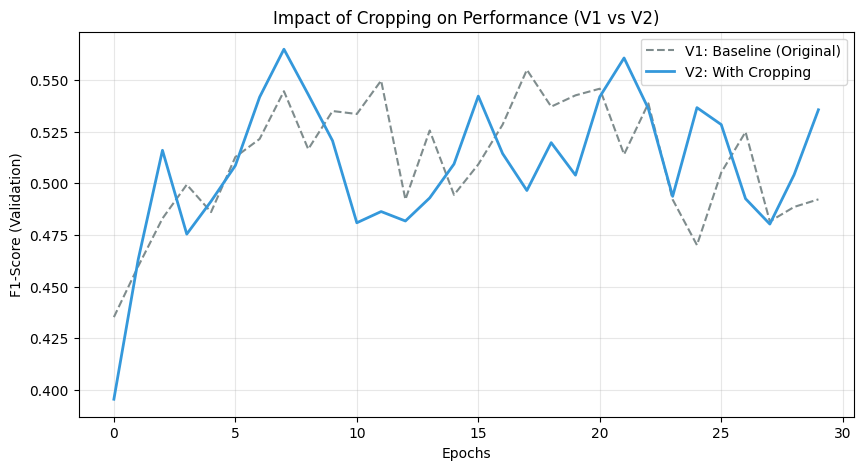

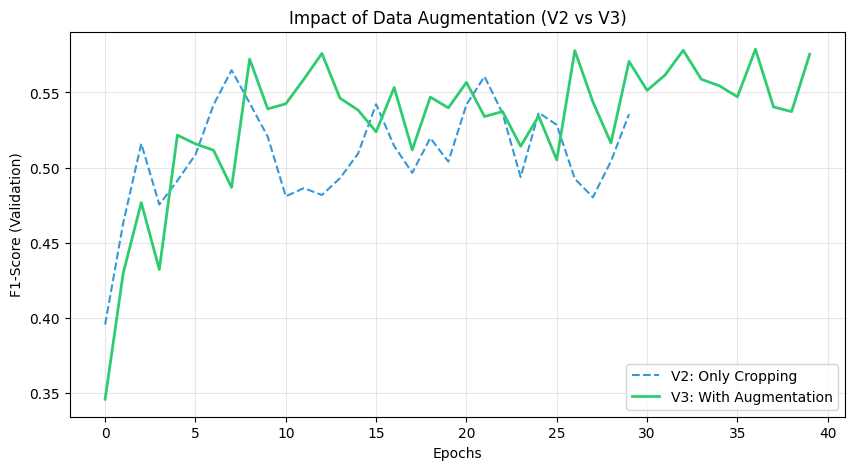

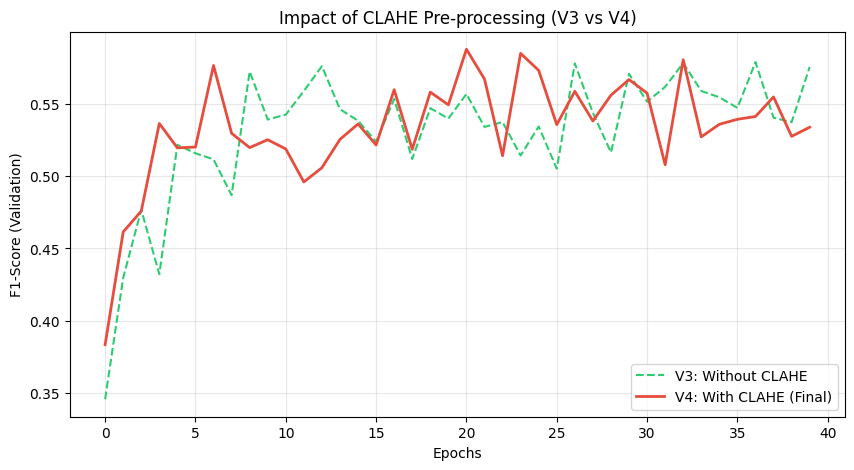

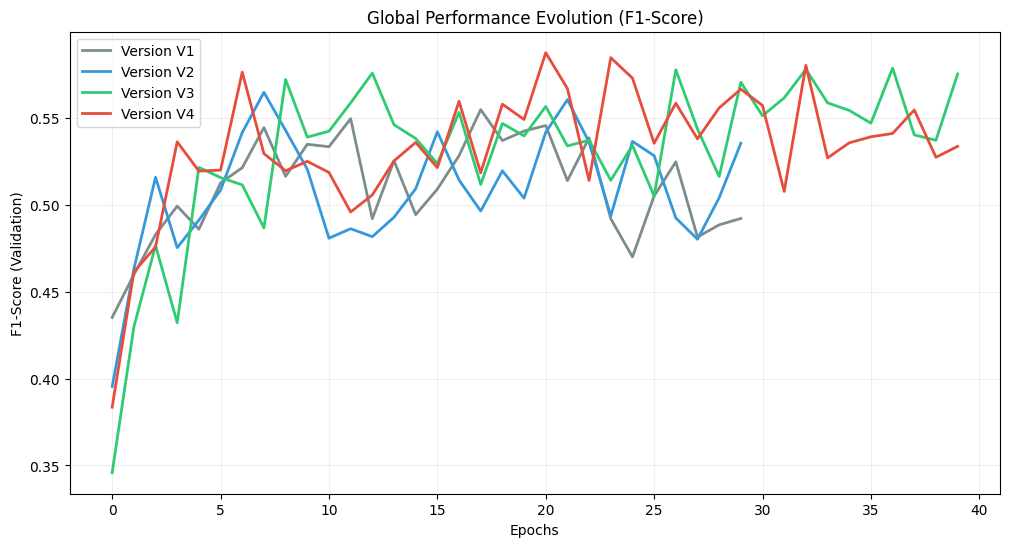


🎯 Calculating Optimized Thresholds for V4...


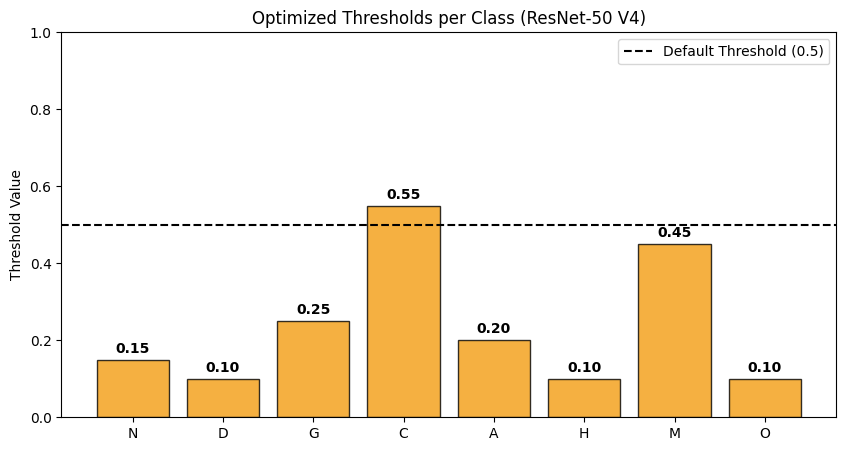


📋 Threshold Summary per Class:
   > Class N: 0.15
   > Class D: 0.10
   > Class G: 0.25
   > Class C: 0.55
   > Class A: 0.20
   > Class H: 0.10
   > Class M: 0.45
   > Class O: 0.10


In [16]:
# ==========================================================
# 📊 SECTION: GRAPHICS & VISUALIZATIONS (COMPARATIVE STUDY)
# ==========================================================
import matplotlib.pyplot as plt
import numpy as np

# Define standard colors for consistency across all plots
colors = {'V1': '#7f8c8d', 'V2': '#3498db', 'V3': '#2ecc71', 'V4': '#e74c3c'}

# --- 1. IMPACT OF CROPPING (V1 vs V2) ---
if 'V1' in results_logs and 'V2' in results_logs:
    plt.figure(figsize=(10, 5))
    plt.plot(results_logs['V1']['history']['val_f1'], label='V1: Baseline (Original)', color=colors['V1'], linestyle='--')
    plt.plot(results_logs['V2']['history']['val_f1'], label='V2: With Cropping', color=colors['V2'], linewidth=2)
    plt.title('Impact of Cropping on Performance (V1 vs V2)')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score (Validation)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('comparison_v1_v2_cropping.png')
    plt.show()

# --- 2. IMPACT OF DATA AUGMENTATION (V2 vs V3) ---
if 'V2' in results_logs and 'V3' in results_logs:
    plt.figure(figsize=(10, 5))
    plt.plot(results_logs['V2']['history']['val_f1'], label='V2: Only Cropping', color=colors['V2'], linestyle='--')
    plt.plot(results_logs['V3']['history']['val_f1'], label='V3: With Augmentation', color=colors['V3'], linewidth=2)
    plt.title('Impact of Data Augmentation (V2 vs V3)')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score (Validation)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('comparison_v2_v3_augmentation.png')
    plt.show()

# --- 3. IMPACT OF CLAHE PRE-PROCESSING (V3 vs V4) ---
if 'V3' in results_logs and 'V4' in results_logs:
    plt.figure(figsize=(10, 5))
    plt.plot(results_logs['V3']['history']['val_f1'], label='V3: Without CLAHE', color=colors['V3'], linestyle='--')
    plt.plot(results_logs['V4']['history']['val_f1'], label='V4: With CLAHE (Final)', color=colors['V4'], linewidth=2)
    plt.title('Impact of CLAHE Pre-processing (V3 vs V4)')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score (Validation)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('comparison_v3_v4_clahe.png')
    plt.show()

# --- 4. GLOBAL PERFORMANCE EVOLUTION ---
plt.figure(figsize=(12, 6))
for v in ['V1', 'V2', 'V3', 'V4']:
    if v in results_logs:
        plt.plot(results_logs[v]['history']['val_f1'], label=f'Version {v}', color=colors[v], linewidth=2)
plt.title('Global Performance Evolution (F1-Score)')
plt.xlabel('Epochs')
plt.ylabel('F1-Score (Validation)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.savefig('global_evolution_f1.png')
plt.show()

# --- 5. OPTIMIZATION AND VISUALIZATION OF THRESHOLDS (V4) ---
if 'V4' in results_logs:
    print("\n🎯 Calculating Optimized Thresholds for V4...")
    v4_res = results_logs['V4']
    
    # Calculate best thresholds
    best_thresholds_v4 = find_best_thresholds(np.array(v4_res['y_true']), np.array(v4_res['y_probs']))
    
    classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    
    # Thresholds Bar Chart
    plt.figure(figsize=(10, 5))
    bars = plt.bar(classes, best_thresholds_v4, color='#f39c12', alpha=0.8, edgecolor='black')
    plt.axhline(y=0.5, color='black', linestyle='--', label='Default Threshold (0.5)')
    
    # Add exact values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}', 
                 ha='center', va='bottom', fontweight='bold')

    plt.title('Optimized Thresholds per Class (ResNet-50 V4)')
    plt.ylabel('Threshold Value')
    plt.ylim(0, 1.0)
    plt.legend()
    plt.savefig('v4_thresholds_bar_chart.png')
    plt.show()

    # Print summary table to console
    print("\n📋 Threshold Summary per Class:")
    for i, cls in enumerate(classes):
        print(f"   > Class {cls}: {best_thresholds_v4[i]:.2f}")

## Grid Search (ResNet-50 V4)

🚀 Iniciando Grid Search para ResNet-50 V4...

> Testando: LR=0.0001 | Batch Size=16
  Final Val F1 para esta config: 0.5389

> Testando: LR=0.0005 | Batch Size=16
  Final Val F1 para esta config: 0.3677

> Testando: LR=0.001 | Batch Size=16
  Final Val F1 para esta config: 0.2874

> Testando: LR=0.0001 | Batch Size=32
  Final Val F1 para esta config: 0.5563

> Testando: LR=0.0005 | Batch Size=32
  Final Val F1 para esta config: 0.4324

> Testando: LR=0.001 | Batch Size=32
  Final Val F1 para esta config: 0.3155

> Testando: LR=0.0001 | Batch Size=64
  Final Val F1 para esta config: 0.5653

> Testando: LR=0.0005 | Batch Size=64
  Final Val F1 para esta config: 0.4705

> Testando: LR=0.001 | Batch Size=64
  Final Val F1 para esta config: 0.3679
✅ Resultados do Grid Search salvos!


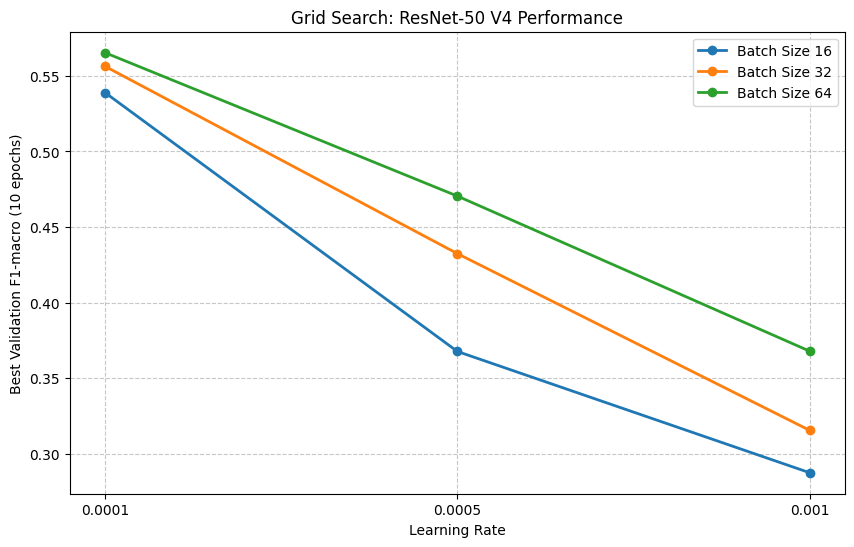

In [72]:
param_grid = {
    'lr': [1e-4, 5e-4, 1e-3],
    'batch_size': [16, 32, 64]
}
MODEL_SAVE_PATH = CURRENT_DIR # Ou onde queres guardar os .pth

config_v4 = {'crop': True, 'augment': 'full', 'clahe': True}
grid_results = []

print("🚀 Iniciando Grid Search para ResNet-50 V4...")

for bs in param_grid['batch_size']:
    # Loader específico para este batch size
    train_ds_grid = ODIRDataset(split='train', transform=get_transforms(config_v4))
    val_ds_grid = ODIRDataset(split='val', transform=get_transforms(config_v4))    
    train_loader_grid = DataLoader(train_ds_grid, batch_size=bs, shuffle=True)
    val_loader_grid = DataLoader(val_ds_grid, batch_size=bs)
    
    for lr in param_grid['lr']:
        print(f"\n> Testando: LR={lr} | Batch Size={bs}")
        model = get_resnet50_model()
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        best_val_f1 = 0
        for epoch in range(10): # 10 épocas conforme pedido
            model.train()
            for imgs, labels in train_loader_grid:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            
            # Validação rápida pós-época
            model.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for imgs, labels in val_loader_grid:
                    outputs = model(imgs.to(device))
                    all_preds.append((outputs > 0.5).cpu().numpy())
                    all_labels.append(labels.numpy())
            
            val_f1 = f1_score(np.vstack(all_labels), np.vstack(all_preds), average='macro', zero_division=0)
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
        
        grid_results.append({'lr': lr, 'batch_size': bs, 'f1': best_val_f1})
        print(f"  Final Val F1 para esta config: {best_val_f1:.4f}")

# Logo após o loop de LR e Batch Size terminar:
with open("grid_search_results.json", "w") as f:
    json.dump(grid_results, f)
print("✅ Resultados do Grid Search salvos!")

# --- Visualização do Grid Search ---
plt.figure(figsize=(10, 6))
for bs in param_grid['batch_size']:
    subset = [r for r in grid_results if r['batch_size'] == bs]
    lrs = [str(r['lr']) for r in subset]
    f1s = [r['f1'] for r in subset]
    plt.plot(lrs, f1s, marker='o', linewidth=2, label=f'Batch Size {bs}')

plt.xlabel('Learning Rate')
plt.ylabel('Best Validation F1-macro (10 epochs)')
plt.title('Grid Search: ResNet-50 V4 Performance')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('hyperparameter_search.png')
plt.show()

In [17]:
# ==========================================================
# 🚀 FINAL TRAINING: ResNet-50 V4 (Best Configuration)
# ==========================================================

# 1. Define the missing 'configs' dictionary
configs = {
    'V1': {'crop': False, 'augment': 'none', 'clahe': False},
    'V2': {'crop': True, 'augment': 'none', 'clahe': False},
    'V3': {'crop': True, 'augment': 'full', 'clahe': False},
    'V4_Best': {'crop': True, 'augment': 'full', 'clahe': True}
}

# 2. Set Hyperparameters
best_lr = 0.0001
best_bs = 64
print(f"🏆 Final Configuration Fixed: LR={best_lr}, Batch={best_bs}")

# 3. Setup DataLoaders
train_ds = ODIRDataset(split='train', transform=get_transforms(configs['V4_Best']))
val_ds = ODIRDataset(split='val', transform=get_transforms(configs['V4_Best']))

train_loader_final = DataLoader(train_ds, batch_size=best_bs, shuffle=True)
val_loader_final = DataLoader(val_ds, batch_size=best_bs)

# 4. Initialize Model, Optimizer, and Scheduler
model = get_resnet50_model().to(device) # Ensure it goes to GPU
optimizer = optim.Adam(model.parameters(), lr=best_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
criterion = nn.BCELoss()

history_v4_best = {'loss': [], 'val_f1': []}
best_f1_global = 0

final_v_probs = [] 
final_v_labels = []

# 5. Training Loop
for epoch in range(50):
    model.train()
    epoch_loss = 0
    for imgs, labels in tqdm(train_loader_final, desc=f"Epoch {epoch+1}/50"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Validation
    model.eval()
    v_probs_batch, v_labels_batch = [], [] 
    with torch.no_grad():
        for imgs, labels in val_loader_final:
            outputs = model(imgs.to(device))
            v_probs_batch.append(outputs.cpu().numpy()) 
            v_labels_batch.append(labels.numpy())
    
    # Stack results for metric calculation
    y_true_epoch = np.vstack(v_labels_batch)
    y_probs_epoch = np.vstack(v_probs_batch)
    y_preds_epoch = (y_probs_epoch > 0.5).astype(int)
    
    val_f1 = f1_score(y_true_epoch, y_preds_epoch, average='macro', zero_division=0)
    
    # Update Scheduler
    scheduler.step(val_f1)
    
    history_v4_best['loss'].append(epoch_loss/len(train_loader_final))
    history_v4_best['val_f1'].append(val_f1)
    
    # Checkpoint: Save the best performing weights
    if val_f1 > best_f1_global:
        best_f1_global = val_f1
        torch.save(model.state_dict(), f"{MODEL_SAVE_PATH}/resnet50_v4_best.pth")
        
        # Save probabilities of the BEST epoch for reporting
        final_v_probs = y_probs_epoch
        final_v_labels = y_true_epoch
        
        print(f"✨ Checkpoint: New Best Val F1 = {val_f1:.4f}")

# 6. Log Results to results_logs
results_logs['V4'] = {
    'history': history_v4_best, 
    'y_true': final_v_labels.tolist(), 
    'y_probs': final_v_probs.tolist()
}
save_results_to_json(results_logs)

print("\n✅ Training Complete for V4 Best!")

🏆 Final Configuration Fixed: LR=0.0001, Batch=64


Epoch 1/50: 100%|██████████| 70/70 [02:16<00:00,  1.95s/it]


✨ Checkpoint: New Best Val F1 = 0.4011


Epoch 2/50: 100%|██████████| 70/70 [02:11<00:00,  1.87s/it]


✨ Checkpoint: New Best Val F1 = 0.4872


Epoch 4/50: 100%|██████████| 70/70 [02:12<00:00,  1.89s/it]


✨ Checkpoint: New Best Val F1 = 0.5015


Epoch 5/50: 100%|██████████| 70/70 [02:12<00:00,  1.89s/it]


✨ Checkpoint: New Best Val F1 = 0.5249


Epoch 7/50: 100%|██████████| 70/70 [02:12<00:00,  1.89s/it]


✨ Checkpoint: New Best Val F1 = 0.5270


Epoch 10/50: 100%|██████████| 70/70 [02:14<00:00,  1.92s/it]


✨ Checkpoint: New Best Val F1 = 0.5456


Epoch 11/50: 100%|██████████| 70/70 [02:14<00:00,  1.92s/it]


✨ Checkpoint: New Best Val F1 = 0.5650


Epoch 18/50: 100%|██████████| 70/70 [02:16<00:00,  1.95s/it]


✨ Checkpoint: New Best Val F1 = 0.5848


Epoch 21/50: 100%|██████████| 70/70 [02:12<00:00,  1.89s/it]


✨ Checkpoint: New Best Val F1 = 0.5850


Epoch 24/50: 100%|██████████| 70/70 [02:12<00:00,  1.90s/it]


✨ Checkpoint: New Best Val F1 = 0.5873


Epoch 27/50: 100%|██████████| 70/70 [02:12<00:00,  1.89s/it]


✨ Checkpoint: New Best Val F1 = 0.5975


Epoch 29/50: 100%|██████████| 70/70 [02:13<00:00,  1.90s/it]


✨ Checkpoint: New Best Val F1 = 0.6002


Epoch 45/50: 100%|██████████| 70/70 [02:14<00:00,  1.93s/it]


✨ Checkpoint: New Best Val F1 = 0.6038


Epoch 46/50: 100%|██████████| 70/70 [02:13<00:00,  1.91s/it]


✨ Checkpoint: New Best Val F1 = 0.6129


Epoch 50/50: 100%|██████████| 70/70 [02:13<00:00,  1.91s/it]


✅ Resultados salvos com sucesso em: odir_experiment_results.json

✅ Training Complete for V4 Best!



🔍 Calculating optimized thresholds for V4...

📊 EVALUATION REPORT: V1
⚙️ Using default threshold (0.5)...
Overall Accuracy: 0.4265
F1-Macro:         0.5415
Cohen's Kappa:    0.4084
AUC-ROC:          0.8211

F1-Score per Disease:
 - N: 0.5793
 - D: 0.6193
 - G: 0.5042
 - C: 0.7414
 - A: 0.4872
 - H: 0.2456
 - M: 0.7895
 - O: 0.3659


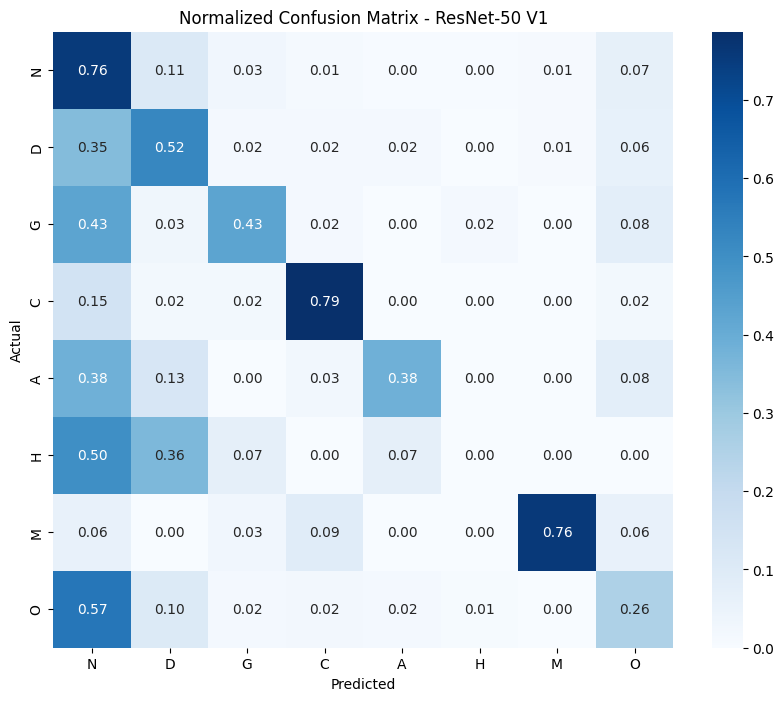


📊 EVALUATION REPORT: V2
⚙️ Using default threshold (0.5)...
Overall Accuracy: 0.3691
F1-Macro:         0.5344
Cohen's Kappa:    0.3694
AUC-ROC:          0.8227

F1-Score per Disease:
 - N: 0.5145
 - D: 0.5676
 - G: 0.4630
 - C: 0.7407
 - A: 0.4750
 - H: 0.3051
 - M: 0.7647
 - O: 0.4444


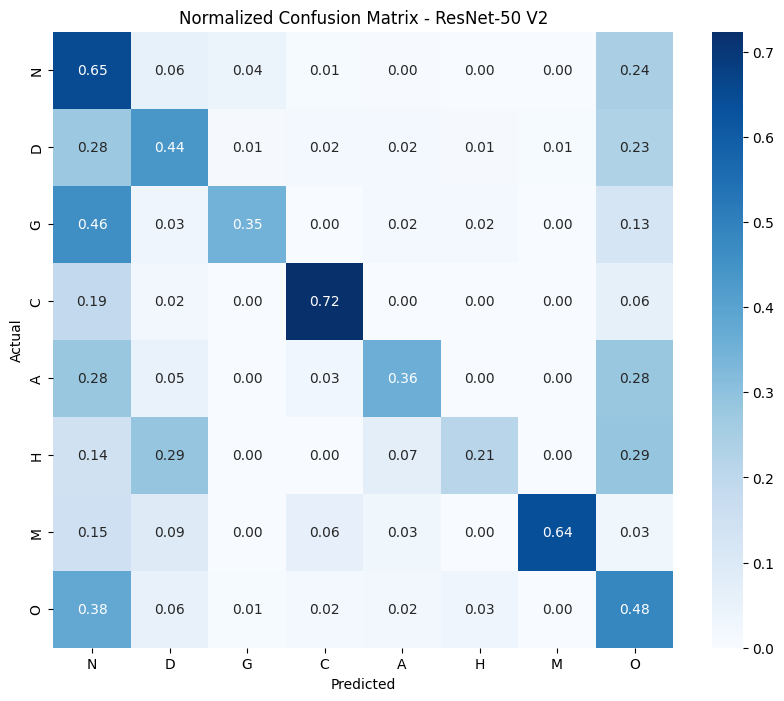


📊 EVALUATION REPORT: V3
⚙️ Using default threshold (0.5)...
Overall Accuracy: 0.4275
F1-Macro:         0.5583
Cohen's Kappa:    0.3935
AUC-ROC:          0.8318

F1-Score per Disease:
 - N: 0.5931
 - D: 0.6084
 - G: 0.5574
 - C: 0.7273
 - A: 0.4819
 - H: 0.3103
 - M: 0.8108
 - O: 0.3768


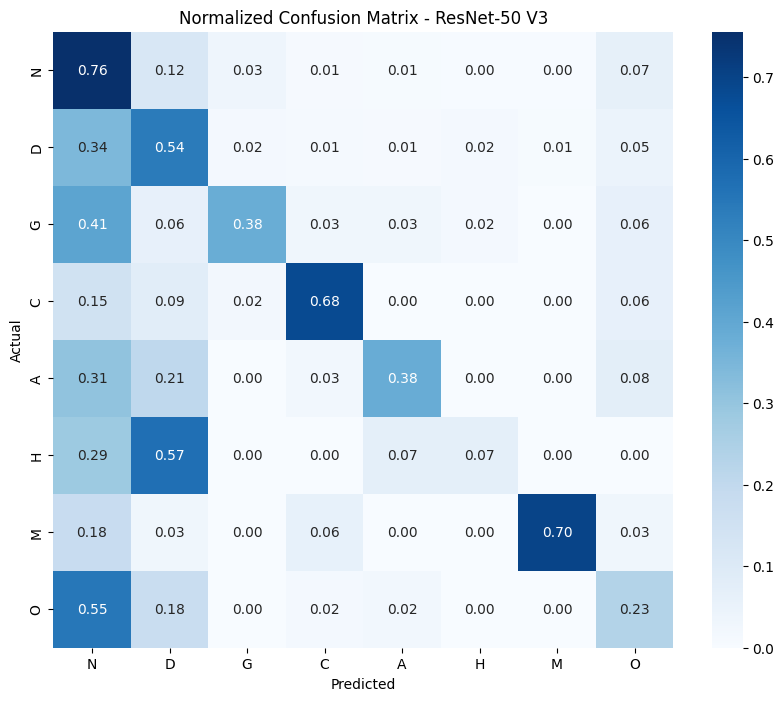


📊 EVALUATION REPORT: V4_Best
⚙️ Applying optimized thresholds...
Overall Accuracy: 0.4380
F1-Macro:         0.5890
Cohen's Kappa:    0.3988
AUC-ROC:          0.8517

F1-Score per Disease:
 - N: 0.5925
 - D: 0.6515
 - G: 0.5636
 - C: 0.7222
 - A: 0.5679
 - H: 0.4068
 - M: 0.7532
 - O: 0.4544


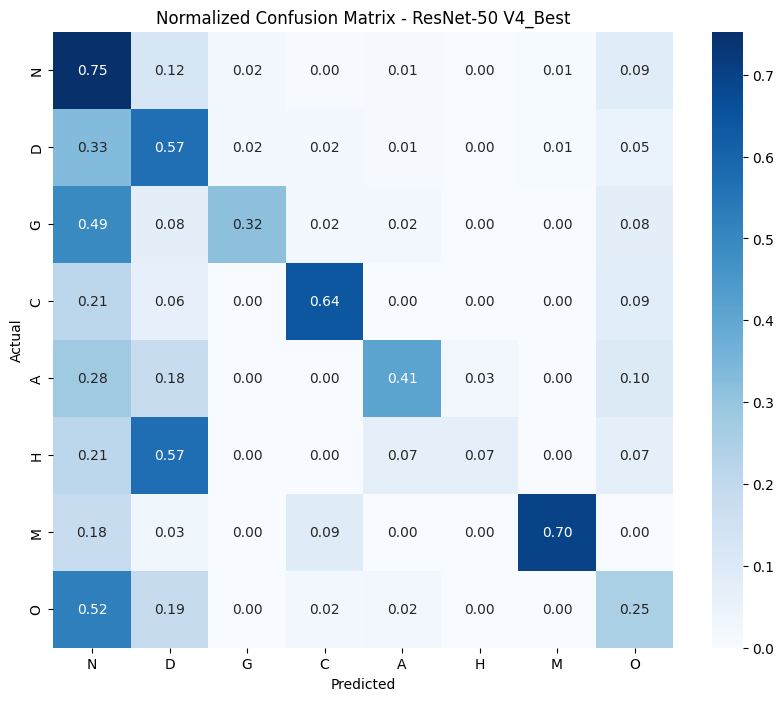


✅ Evaluation complete! Metrics saved to: /kaggle/working/odir_final_evaluation_metrics.json


In [18]:
def final_evaluation_report(model_path, config, version_name, thresholds=None):
    print(f"\n" + "="*40)
    print(f"📊 EVALUATION REPORT: {version_name}")
    print("="*40)
    
    model = get_resnet50_model()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    test_ds = ODIRDataset(split='test', transform=get_transforms(config))
    test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
    
    y_true, y_prob = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            outputs = model(imgs.to(device))
            y_prob.append(outputs.cpu().numpy())
            y_true.append(labels.numpy())
    
    y_true = np.vstack(y_true)
    y_prob = np.vstack(y_prob)
    
    # Threshold Application
    if thresholds is not None:
        print("⚙️ Applying optimized thresholds...")
        y_pred = np.zeros_like(y_prob)
        for i in range(8):
            y_pred[:, i] = (y_prob[:, i] > thresholds[i]).astype(int)
    else:
        print("⚙️ Using default threshold (0.5)...")
        y_pred = (y_prob > 0.5).astype(int)
        
    classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    
    # 1. Metric Calculation
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    kappa = cohen_kappa_score(y_true.argmax(1), y_pred.argmax(1))
    auc_roc = roc_auc_score(y_true, y_prob, average='macro')
    
    print(f"Overall Accuracy: {acc:.4f}")
    print(f"F1-Macro:         {f1_macro:.4f}")
    print(f"Cohen's Kappa:    {kappa:.4f}")
    print(f"AUC-ROC:          {auc_roc:.4f}")

    # 2. F1-Score per Class
    f1_per_class = {}
    print("\nF1-Score per Disease:")
    for i, cls in enumerate(classes):
        score = f1_score(y_true[:, i], y_pred[:, i])
        f1_per_class[cls] = float(score)
        print(f" - {cls}: {score:.4f}")
        
    # 3. Normalized Confusion Matrix (Graphic in English)
    cm = confusion_matrix(y_true.argmax(1), y_pred.argmax(1), normalize='true')
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title(f'Normalized Confusion Matrix - ResNet-50 {version_name}')
    plt.xlabel('Predicted') # Translated
    plt.ylabel('Actual')    # Translated
    plt.savefig(f'confusion_matrix_{version_name.lower()}.png')
    plt.show()

    return {
        'overall_accuracy': float(acc),
        'f1_macro': float(f1_macro),
        'cohen_kappa': float(kappa),
        'auc_roc': float(auc_roc),
        'f1_per_class': f1_per_class,
        'thresholds_used': thresholds.tolist() if thresholds is not None else None
    }

# --- 1. Report Configurations ---
configs = {
    'V1': {'crop': False, 'augment': 'none', 'clahe': False},
    'V2': {'crop': True, 'augment': 'none', 'clahe': False},
    'V3': {'crop': True, 'augment': 'full', 'clahe': False},
    'V4_Best': {'crop': True, 'augment': 'full', 'clahe': True}
}

# --- 2. Threshold Optimization (V4 Only) ---
print("\n🔍 Calculating optimized thresholds for V4...")
if 'V4' in results_logs:
    v4_data = results_logs['V4']
    y_true_v4 = np.array(v4_data['y_true'])
    y_probs_v4 = np.array(v4_data['y_probs'])
    best_thresholds_v4 = find_best_thresholds(y_true_v4, y_probs_v4)
else:
    print("⚠️ Warning: V4 data not found in results_logs. Using 0.5 by default.")
    best_thresholds_v4 = np.ones(8) * 0.5

# --- 3. Final Evaluation Loop ---
final_metrics_comparison = {}

model_list = [
    ('resnet50_best_V1.pth', configs['V1'], 'V1'),
    ('resnet50_best_V2.pth', configs['V2'], 'V2'),
    ('resnet50_best_V3.pth', configs['V3'], 'V3'),
    ('resnet50_v4_best.pth', configs['V4_Best'], 'V4_Best')
]

for m_file, m_cfg, m_name in model_list:
    full_path = os.path.join(MODEL_SAVE_PATH, m_file)
    
    if os.path.exists(full_path):
        current_thresholds = best_thresholds_v4 if 'V4' in m_name else None
        
        report_data = final_evaluation_report(
            model_path=full_path, 
            config=m_cfg, 
            version_name=m_name, 
            thresholds=current_thresholds
        )
        
        final_metrics_comparison[m_name] = report_data
        torch.cuda.empty_cache()
    else:
        print(f"❌ Error: File {m_file} not found in {MODEL_SAVE_PATH}")

# --- 4. Save Final JSON ---
final_json_path = "/kaggle/working/odir_final_evaluation_metrics.json"
with open(final_json_path, 'w') as f:
    json.dump(final_metrics_comparison, f, indent=4)

print(f"\n✅ Evaluation complete! Metrics saved to: {final_json_path}")

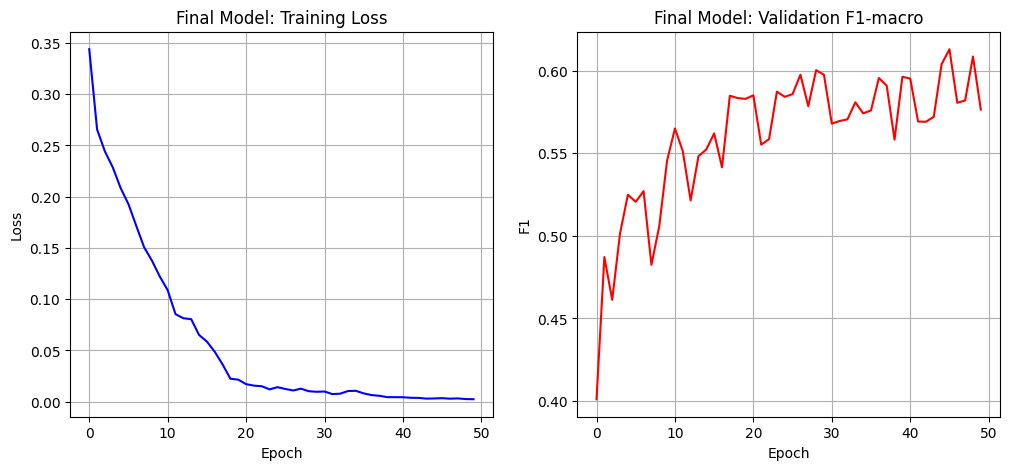

In [19]:
def plot_final_curves(history):
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss', color='blue')
    plt.title('Final Model: Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot F1
    plt.subplot(1, 2, 2)
    plt.plot(history['val_f1'], label='Val F1', color='red')
    plt.title('Final Model: Validation F1-macro')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.grid(True)
    
    plt.savefig('final_training_curves.png')
    plt.show()

plot_final_curves(history_v4_best)

In [21]:
#!pip install grad-cam

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
# ==========================================================
# 🔍 SECTION: EXPLAINABLE AI (Grad-CAM)
# ==========================================================

# 1. Setup Test DataLoader for XAI
# We need to recreate the loader so it's accessible globally
xai_test_ds = ODIRDataset(split='test', transform=get_transforms(configs['V4_Best']))
xai_test_loader = DataLoader(xai_test_ds, batch_size=32, shuffle=False)

def generate_xai_reports(model, test_loader, device, version_name, max_cases=2):
    model.eval()
    # Using the last convolutional layer of ResNet-50
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    
    classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    xai_data_for_report = []
    
    counts = {"SUCCESS": 0, "FAILURE": 0}
    
    print(f"🕵️ Starting Explainable AI (Grad-CAM) for {version_name}...")

    for imgs, labels in test_loader:
        imgs_dev = imgs.to(device)
        outputs = model(imgs_dev)
        probs = torch.sigmoid(outputs) 
        preds = (probs > 0.5).int().cpu().numpy()
        labels_np = labels.numpy()
        probs_np = probs.detach().cpu().numpy()

        for i in range(imgs.shape[0]):
            # Check if all labels match (Multi-label correctness)
            is_correct = np.array_equal(preds[i], labels_np[i])
            type_str = "SUCCESS" if is_correct else "FAILURE"
            
            if counts[type_str] >= max_cases:
                continue

            counts[type_str] += 1
            
            # --- Generate Grad-CAM ---
            # Focus on the Ground Truth class to see what features the model noticed
            target_idx = labels_np[i].argmax() 
            targets = [ClassifierOutputTarget(target_idx)]
            
            grayscale_cam = cam(input_tensor=imgs_dev[i:i+1], targets=targets)[0, :]
            
            # Denormalize image for visualization
            img_original = imgs[i].permute(1, 2, 0).numpy()
            img_original = (img_original - img_original.min()) / (img_original.max() - img_original.min())
            
            visualization = show_cam_on_image(img_original, grayscale_cam, use_rgb=True)

            # --- Save Composite Image ---
            filename = f"xai_{version_name.lower()}_{type_str}_case{i}.png"
            fig, ax = plt.subplots(1, 2, figsize=(15, 7))
            
            ax[0].imshow(img_original)
            ax[0].set_title(f"Original - Real Class: {classes[target_idx]}")
            ax[0].axis('off')
            
            ax[1].imshow(visualization)
            pred_idx = probs_np[i].argmax()
            ax[1].set_title(f"Grad-CAM {type_str}\nTop Prediction: {classes[pred_idx]} ({probs_np[i][pred_idx]:.2f})")
            ax[1].axis('off')
            
            plt.tight_layout()
            plt.savefig(f"/kaggle/working/{filename}")
            plt.close()

            # --- Metadata for Carolina & Matilde ---
            case_info = {
                "case_type": type_str,
                "image_file": filename,
                "ground_truth": [classes[j] for j, val in enumerate(labels_np[i]) if val == 1],
                "model_prediction": [classes[j] for j, val in enumerate(preds[i]) if val == 1],
                "confidence_scores": {classes[j]: float(probs_np[i][j]) for j in range(8)},
                "analyzed_class": classes[target_idx]
            }
            xai_data_for_report.append(case_info)
            print(f"✅ Generated: {filename}")

        if counts["SUCCESS"] >= max_cases and counts["FAILURE"] >= max_cases:
            break

    # Save JSON metadata file
    json_filename = f"xai_metadata_{version_name.lower()}.json"
    with open(f"/kaggle/working/{json_filename}", "w") as f:
        json.dump(xai_data_for_report, f, indent=4)
    
    print(f"\n📁 XAI Complete! Send '{json_filename}' and the generated images to your colleagues.")

# 2. Run XAI with the global xai_test_loader
generate_xai_reports(model, xai_test_loader, device, "V4_Best")

🕵️ Starting Explainable AI (Grad-CAM) for V4_Best...
✅ Generated: xai_v4_best_FAILURE_case0.png
✅ Generated: xai_v4_best_FAILURE_case1.png

📁 XAI Complete! Send 'xai_metadata_v4_best.json' and the generated images to your colleagues.


In [ ]:
# ==========================================================
# 🔄 SECTION: 5-FOLD CV + LABEL SMOOTHING (INTEGRATED)
# ==========================================================
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import json
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from torchvision import models

# --- 1. DATASET SETUP ---
class ODIRKFoldDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform
        self.label_cols = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        filename = row['filename']
        path_train = os.path.join(DATASET_ROOT, 'train', filename)
        path_val = os.path.join(DATASET_ROOT, 'val', filename)
        img_path = path_train if os.path.exists(path_train) else path_val
        image = Image.open(img_path).convert('RGB')
        labels = torch.tensor(row[self.label_cols].values.astype(np.float32))
        if self.transform:
            image = self.transform(image)
        return image, labels

# --- 2. MODEL & METRICS ---
def get_resnet50_kfold():
    model = models.resnet50(weights='IMAGENET1K_V1')
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 8) 
    return model.to(device)

def evaluate_fold_metrics(model, loader, device):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            logits = model(imgs.to(device))
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
    
    y_true = np.vstack(all_labels)
    y_prob = np.vstack(all_probs)
    
    best_f1 = 0
    best_t = 0.2
    # Thresholds agressivos para tirar o F1 do zero
    for t in [0.05, 0.1, 0.15, 0.2, 0.25]:
        current_f1 = f1_score(y_true, (y_prob > t).astype(int), average='macro', zero_division=0)
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_t = t
            
    acc = accuracy_score(y_true, (y_prob > best_t).astype(int))
    try:
        auc = roc_auc_score(y_true, y_prob, average='macro', multi_class='ovr')
    except:
        auc = 0.0
        
    return {'acc': acc, 'f1': best_f1, 'auc': auc}

# --- 3. CROSS-VALIDATION LOOP WITH LABEL SMOOTHING ---
full_train_df = pd.concat([train_df, val_df], ignore_index=True)
disease_classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
X = full_train_df.index.values
y = full_train_df[disease_classes].values

weights = torch.tensor([1.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]).to(device)
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kfold_results = []

print(f"🚀 Starting 5-Fold CV with Label Smoothing...")

for fold, (train_idx, val_idx) in enumerate(mskf.split(X, y)):
    print(f"\n{'='*25} FOLD {fold+1}/5 {'='*25}")
    
    train_fold_df = full_train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = full_train_df.iloc[val_idx].reset_index(drop=True)
    
    train_ds = ODIRKFoldDataset(train_fold_df, transform=get_transforms(configs['V4_Best']))
    val_ds = ODIRKFoldDataset(val_fold_df, transform=get_transforms(configs['V4_Best']))
    
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
    
    model = get_resnet50_kfold()
    criterion = nn.BCEWithLogitsLoss(pos_weight=weights) 
    optimizer = optim.Adam(model.parameters(), lr=1e-4) # LR aumentada
    
    best_fold_f1 = -1 # Começa em -1 para garantir que grava o primeiro
    num_epochs = 12   # 12 épocas chegam com esta LR

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            
            # Removido o Label Smoothing para o modelo focar totalmente nas labels reais
            loss = criterion(outputs, labels) 
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        metrics = evaluate_fold_metrics(model, val_loader, device)
        
        # Grava se houver melhoria OU se for a primeira época (para evitar o FileNotFoundError)
        if metrics['f1'] >= best_fold_f1 or epoch == 0:
            best_fold_f1 = metrics['f1']
            torch.save(model.state_dict(), f"resnet50_v4_fold{fold+1}.pth")
            
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss/len(train_loader):.4f} | Val F1: {metrics['f1']:.4f}")
        
# --- 4. POST-PROCESSING & ANALYSIS ---
df_kfold = pd.DataFrame(kfold_results)
mean_vals = df_kfold[['acc', 'f1', 'auc']].mean()
std_vals = df_kfold[['acc', 'f1', 'auc']].std()

with open("kfold_splits.pkl", "wb") as f:
    pickle.dump({'last_fold_train_idx': train_idx, 'last_fold_val_idx': val_idx}, f)

summary_stats = {'mean': mean_vals.to_dict(), 'std': std_vals.to_dict(), 'detailed_folds': kfold_results}
with open("odir_v4_kfold_final_results.json", "w") as f:
    json.dump(summary_stats, f, indent=4)

print("\n" + "="*60)
print(f"{'Fold':<8} | {'Accuracy':<10} | {'F1-Score':<10} | {'AUC':<10}")
print("-" * 60)
for _, row in df_kfold.iterrows():
    print(f"{int(row['fold']):<8} | {row['acc']:<10.3f} | {row['f1']:<10.3f} | {row['auc']:<10.3f}")
print("-" * 60)
print(f"{'MEAN':<8} | {mean_vals['acc']:<10.3f} | {mean_vals['f1']:<10.3f} | {mean_vals['auc']:<10.3f}")
print(f"{'STD':<8} | {std_vals['acc']:<10.3f} | {std_vals['f1']:<10.3f} | {std_vals['auc']:<10.3f}")
print("="*60)

f1_std_percent = std_vals['f1'] * 100
print(f"\n📝 ANALYSIS:")
if f1_std_percent < 1.0:
    print(f"✅ The model is highly stable (STD: {f1_std_percent:.2f}%).")
else:
    print(f"⚠️ The model shows some variance between folds (STD: {f1_std_percent:.2f}%).")

best_fold_idx = df_kfold['f1'].idxmax()
print(f"⭐ Best performance found in Fold {int(df_kfold.iloc[best_fold_idx]['fold'])}")

🚀 Starting 5-Fold CV with Label Smoothing...

========================= FOLD 1/5 =========================
Epoch 1/12 | Loss: 0.0379 | Val F1: 0.0000
Epoch 2/12 | Loss: 0.0015 | Val F1: 0.0000
Epoch 3/12 | Loss: 0.0007 | Val F1: 0.0000
Epoch 4/12 | Loss: 0.0004 | Val F1: 0.0000
